In [1]:
# Dependencies
import os
import json
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# reading in JSON data
#JSON data was pulled filtering on Atlanta
with open('../raw_data/atl_weather.json') as f:
  data = json.load(f)

In [3]:
#changing from JSON format into a list

clean_dict_list = []
for x in range(len(data)):
    date = data[x]['dt']
    weather_id = data[x]["weather"][0]["id"]
    weather_group = data[x]["weather"][0]["main"]
    weather = data[x]["weather"][0]["description"]
    temperature = data[x]["main"]["temp"]

    
    weather_dict = {
        "date": date,
        "weather_group": weather_group,
        "weather": weather,
        "temperature": temperature,
    }
    
    clean_dict_list.append(weather_dict)
    


In [4]:
# converting into a DF
df = pd.DataFrame(clean_dict_list)

In [5]:
# date is in UNIX format, convert to datetime
df['date'] = pd.to_datetime(df['date'],unit = 's') 

#datetime is in hours/seconds, use dt.date to remove hours
df['date'] = df['date'].dt.date

# converting report date to match format of weather data
df['date'] = pd.to_datetime(df['date'])

df.tail()


,date,weather_group,weather,temperature
98587,2020-03-31,Clouds,overcast clouds,56.14
98588,2020-03-31,Clouds,overcast clouds,56.97
98589,2020-03-31,Clouds,overcast clouds,56.53
98590,2020-03-31,Rain,light rain,55.89
98591,2020-03-31,Rain,light rain,51.58


In [6]:
# finding unique categories for weather and weather group
print(df['weather'].unique())
print(df['weather_group'].unique())

['sky is clear' 'few clouds' 'scattered clouds' 'overcast clouds'
 'moderate rain' 'light rain' 'mist' 'fog' 'thunderstorm'
 'heavy intensity rain' 'broken clouds' 'thunderstorm with rain' 'haze'
 'light snow' 'light intensity drizzle' 'snow'
 'thunderstorm with heavy rain' 'thunderstorm with light rain'
 'proximity squalls' 'very heavy rain' 'drizzle' 'freezing rain'
 'heavy snow' 'proximity thunderstorm' 'smoke' 'shower rain']
['Clear' 'Clouds' 'Rain' 'Mist' 'Fog' 'Thunderstorm' 'Haze' 'Snow'
 'Drizzle' 'Squall' 'Smoke']


In [7]:
#create a function that goes through each row to see if the weather group is
# rain, thunderstorm or snow. If it is any of these categories then it returns 
# a 1, if it is not then it returns a 0
def weather_variable (row):
    if row['weather_group'] == 'Rain':
        return 1
    if row['weather_group'] == 'Thunderstorm':
        return 1
    if row['weather_group'] == 'Snow':
        return 1
    return 0

# applying the function to go through every row and create a new column called 'rainy'

df['percentage_rain'] = df.apply(lambda row:weather_variable(row),axis = 1)

In [8]:
# grouping by day, finding the mean values of temperature and our rainy number
# if rainy is > 0 this is the percentage of times rain occured
# if rainy = 0 this means there was no rain that day

df1 = df.groupby(df.date).mean().reset_index()
df1.head()

,date,temperature,percentage_rain
0,2009-01-01,36.484167,0.000000
1,2009-01-02,41.464167,0.291667
2,2009-01-03,49.450417,0.083333
3,2009-01-04,57.434583,0.291667
4,2009-01-05,60.162500,0.208333


In [9]:
# making the same type of function this time for rainy column
# if rainy > 0 then rain_indicator = 1, if rainy = 0 ,then rain_indicator = 0
# If a day has a 1 then there was rain on that day

def rain_indicator (row):
    if row['percentage_rain'] > 0:
        return 1
    return 0

df1['rain_indicator'] = df1.apply(lambda row:rain_indicator(row),axis = 1)
df1.head()


,date,temperature,percentage_rain,rain_indicator
0,2009-01-01,36.484167,0.000000,0
1,2009-01-02,41.464167,0.291667,1
2,2009-01-03,49.450417,0.083333,1
3,2009-01-04,57.434583,0.291667,1
4,2009-01-05,60.162500,0.208333,1


In [10]:
# converting to a CSV
df1.to_csv('../raw_data/weather_clean.csv')

In [11]:
#importing crime data
file = "../raw_data/all_crime.csv"
crime = pd.read_csv(file)
crime['crime_type'].unique()

array(['LARCENY-NON VEHICLE', 'LARCENY-FROM VEHICLE',
       'ROBBERY-PEDESTRIAN', 'AUTO THEFT', 'AGG ASSAULT',
       'BURGLARY-RESIDENCE', 'BURGLARY-NONRES', 'ROBBERY-COMMERCIAL',
       'ROBBERY-RESIDENCE', 'HOMICIDE', 'MANSLAUGHTER'], dtype=object)

In [12]:
def combining_crimes (row):
    if row['crime_type'] == 'ROBBERY-PEDESTRIAN':
        return 'ROBBERY'
    if row['crime_type'] == 'ROBBERY-RESIDENCE':
        return 'ROBBERY'
    if row['crime_type'] == 'ROBBERY-COMMERCIAL':
        return 'ROBBERY'
    if row['crime_type'] == 'BURGLARY-PEDESTRIAN':
        return 'BURGLARY'
    if row['crime_type'] == 'BURGLARY-NONRES':
        return 'BURGLARY'
    if row['crime_type'] == 'BURGLARY-RESIDENCE':
        return 'BURGLARY'
    if row['crime_type'] == 'LARCENY-NON VEHICLE':
        return 'LARCENY'
    if row['crime_type'] == 'LARCENY-FROM VEHICLE':
        return 'LARCENY'
    return row['crime_type']

crime['type_crime'] = crime.apply(lambda row:combining_crimes(row),axis = 1)
crime['type_crime'].unique()

array(['LARCENY', 'ROBBERY', 'AUTO THEFT', 'AGG ASSAULT', 'BURGLARY',
       'HOMICIDE', 'MANSLAUGHTER'], dtype=object)

In [30]:
list_of_crimes = ['LARCENY', 'ROBBERY', 'AUTO THEFT', 'AGG ASSAULT', 'BURGLARY',
       'HOMICIDE']
list_of_crimes

['LARCENY', 'ROBBERY', 'AUTO THEFT', 'AGG ASSAULT', 'BURGLARY', 'HOMICIDE']

In [14]:
crimestypes = crime[['type_crime','index']].groupby('type_crime').count().sort_values('index', ascending = False)
crimestypes

,index
type_crime,
LARCENY,191547
BURGLARY,61147
AUTO THEFT,47850
AGG ASSAULT,25547
ROBBERY,21931
HOMICIDE,1003
MANSLAUGHTER,5


In [15]:
# converting report date to match format of weather data
crime['report_date'] = pd.to_datetime(crime['report_date'])

# adding a column splitting off the year, this is used for filtering by year and final regression analysis
crime['year']=crime['report_date'].dt.year
crime.head(1)

,index,crime_type,report_date,Beat,Neigborhood,NPU,lat,lon,type_crime,year
0,0,LARCENY-NON VEHICLE,2009-02-28,301.0,Adair Park,V,33.7271,-84.4136,LARCENY,2009


In [16]:
# renaming columns to prepare for merge
crime = crime.rename(columns = {'report_date':'date'})

# joining with weather data
crime_weather = pd.merge(crime, df1, how = 'inner', on = 'date'  )
crime_weather.drop(columns = ['crime_type']).head(2)

,index,date,Beat,Neigborhood,NPU,lat,lon,type_crime,year,temperature,percentage_rain,rain_indicator
0,0,2009-02-28,301.0,Adair Park,V,33.72710,-84.41360,LARCENY,2009,55.47125,0.916667,1
1,1,2009-02-28,509.0,Downtown,M,33.76158,-84.38496,LARCENY,2009,55.47125,0.916667,1


In [17]:
# exporting data/crime combo data for importing to DB
crime_weather.to_csv('../raw_data/crime_weather.csv')

In [18]:
# creating total crime by date
# first groupbying by report date and year, getting the count, resetting index, renaming columns
crime_all = crime[['crime_type','date','year']].groupby(['date','year']).count().reset_index().rename(columns = {'crime_type':'All_Crime'})

# joining with weather data
crime_all_weather = pd.merge(crime_all, df1, how = 'inner', on = 'date'  )
crime_all_weather.head(1)

,date,year,All_Crime,temperature,percentage_rain,rain_indicator
0,2009-01-01,2009,114,36.484167,0.0,0


In [19]:
crime.head(1)

,index,crime_type,date,Beat,Neigborhood,NPU,lat,lon,type_crime,year
0,0,LARCENY-NON VEHICLE,2009-02-28,301.0,Adair Park,V,33.7271,-84.4136,LARCENY,2009


In [20]:
crime_by_type = crime[['type_crime','date','Beat','year']].groupby(['date','year','type_crime']).count().reset_index().rename(columns = {'Beat':'Crime_by_type'})

# joining with weather data
crime_type_weather = pd.merge(crime_by_type, df1, how = 'inner', on = 'date'  )
crime_type_weather.head(1)

,date,year,type_crime,Crime_by_type,temperature,percentage_rain,rain_indicator
0,2009-01-01,2009,AGG ASSAULT,10,36.484167,0.0,0


In [21]:
dummies = pd.get_dummies(crime_all_weather['year'])
reg_allcrime = pd.concat([crime_all_weather,dummies],axis = 1)

dummies = pd.get_dummies(crime_type_weather['year'])
reg_crimetype = pd.concat([crime_type_weather,dummies],axis = 1)

In [22]:
reg_crimetype.head(1)

,date,year,type_crime,Crime_by_type,temperature,percentage_rain,rain_indicator,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,2009-01-01,2009,AGG ASSAULT,10,36.484167,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0


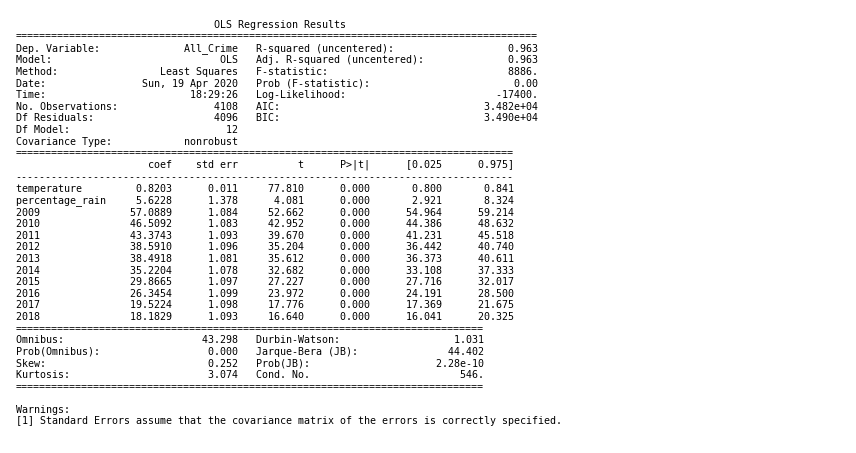

In [33]:
# running regressions
#model is | levels of crime = 1.2*temperature + 9.8*(percent of day that is rainy)

# x = crime_all_weather[['temperature','year']].loc[crime_all_weather['year']==2009].drop(columns = ['year'])
x = reg_allcrime[['temperature','percentage_rain',2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]]
y = reg_allcrime['All_Crime']

model = sm.OLS(y,x).fit()
predictions = model.predict(x)

# model.summary()

plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('../images/regression_all_crime.png')

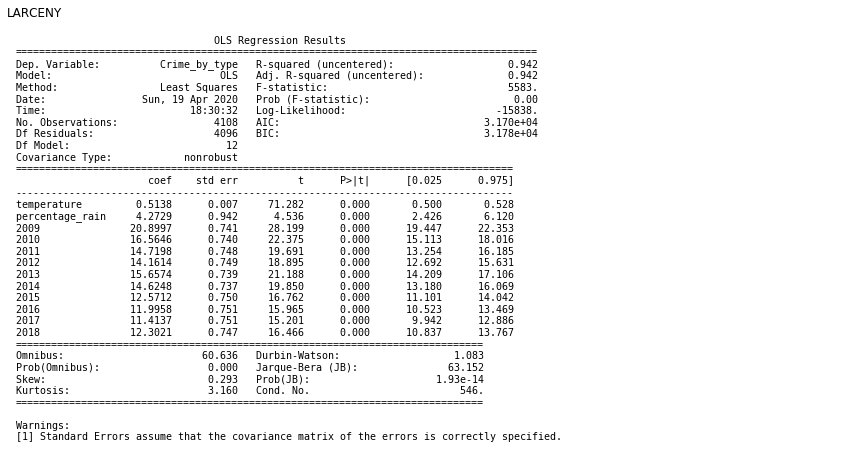

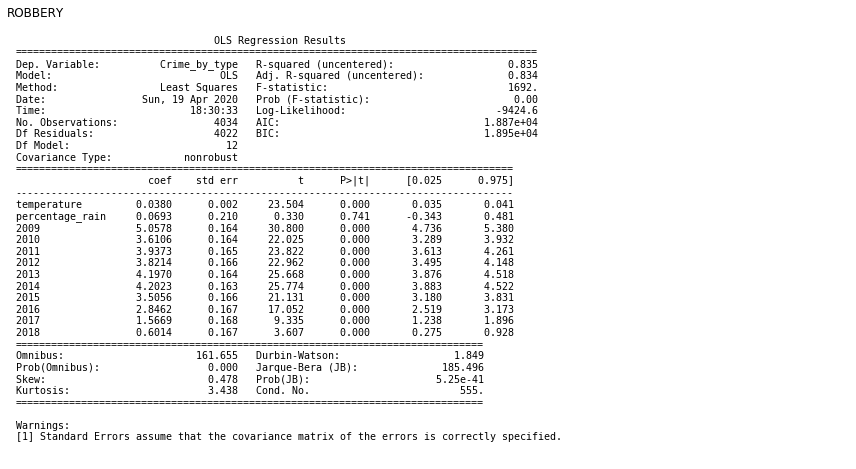

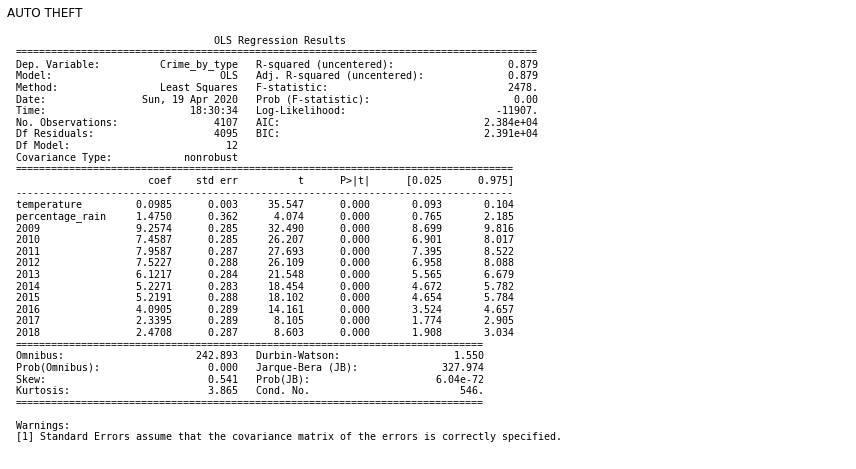

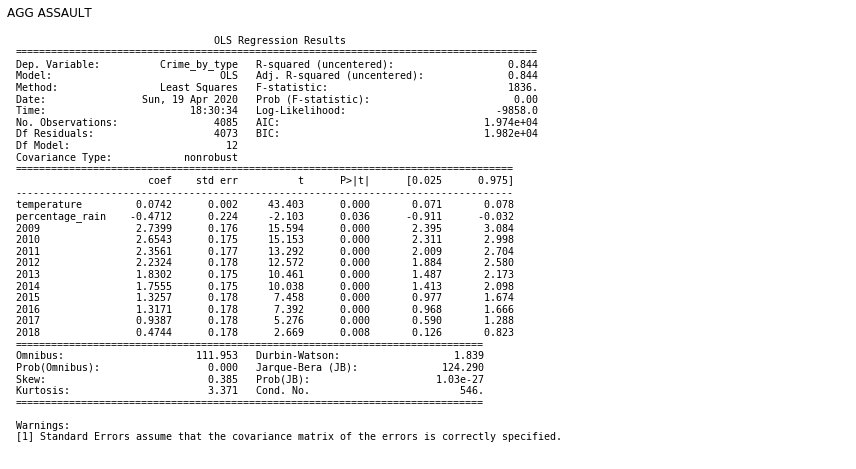

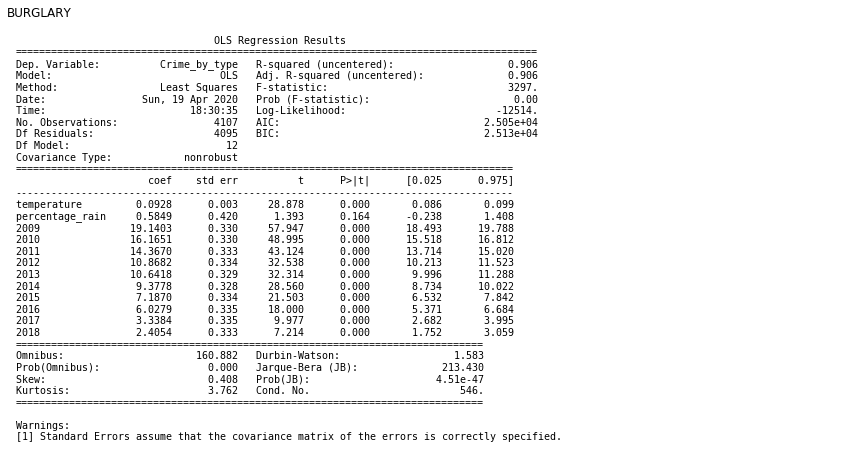

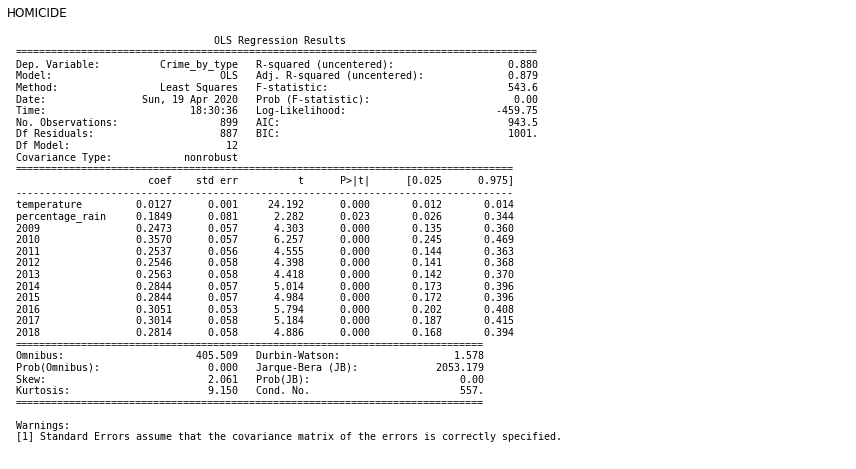

In [35]:
# running regressions
#model is | levels of crime = 1.2*temperature + 9.8*(percent of day that is rainy)
count = 0

for tc in list_of_crimes:
    x0 = reg_crimetype[['type_crime','Crime_by_type','temperature','percentage_rain',2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]].loc[reg_crimetype['type_crime']== tc,:]
    x1 = x0.drop(columns=['type_crime','Crime_by_type'])
    y1 = reg_crimetype.loc[reg_crimetype['type_crime']== tc,'Crime_by_type']
# # 

    model = sm.OLS(y1,x1).fit()
    predictions = model.predict(x1)
    plt.rc('figure', figsize=(12, 7))
    plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}, fontproperties = 'monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.title(tc, loc = 'left')
    plt.savefig('../images/regression{num}.png'.format(num=count))
    count += 1
    plt.show()
  


In [25]:
# adding a column for predicted values based on OLS model

crime_all_weather['forecasted_crime'] = crime_all_weather['temperature']*.82 + crime_all_weather['percentage_rain']*5.6

crime_all_weather.to_csv('../raw_data/crime_weather_fore.csv')

In [26]:
# filtering by month and day of groups birth day/month for random sample
test_set = crime_all_weather.loc[(crime_all_weather['date'] >= '2019-04-05') & 
                                  (crime_all_weather['date'] < '2019-04-12')  |
                                  (crime_all_weather['date'] >= '2019-05-25') & 
                                  (crime_all_weather['date'] < '2019-06-02')  |
                                  (crime_all_weather['date'] >= '2019-05-31') &
                                  (crime_all_weather['date'] < '2019-06-06')  |
                                  (crime_all_weather['date'] >= '2019-07-02') & 
                                  (crime_all_weather['date'] < '2019-07-09')  |
                                  (crime_all_weather['date'] >= '2019-07-02') & (crime_all_weather['date'] < '2019-07-09')]
# test_set5 = crime_all_weather.loc[(crime_all_weather['date'] >= '2019-07-02') & (crime_all_weather['date'] < '2019-07-09')]
test_set.to_csv('../raw_data/test_set.csv')
test_set.head()

,date,year,All_Crime,temperature,percentage_rain,rain_indicator,forecasted_crime
3746,2019-04-05,2019,46,61.820000,0.500000,1,53.492400
3747,2019-04-06,2019,77,63.310417,0.000000,0,51.914542
3748,2019-04-07,2019,45,67.984583,0.250000,1,57.147358
3749,2019-04-08,2019,54,68.505417,0.166667,1,57.107775
3750,2019-04-09,2019,61,67.098333,0.291667,1,56.653967


In [27]:
# filtering by month and day of groups birth day/month for random sample
test_set0 = crime_all_weather.loc[(crime_all_weather['date'] >= '2019-04-05') & (crime_all_weather['date'] < '2019-04-12')]
test_set1 = crime_all_weather.loc[(crime_all_weather['date'] >= '2019-05-25') & (crime_all_weather['date'] < '2019-06-02')]
test_set2 = crime_all_weather.loc[(crime_all_weather['date'] >= '2019-05-31') & (crime_all_weather['date'] < '2019-06-06')]
test_set3 = crime_all_weather.loc[(crime_all_weather['date'] >= '2019-07-02') & (crime_all_weather['date'] < '2019-07-09')]
test_set4 = crime_all_weather.loc[(crime_all_weather['date'] >= '2019-07-02') & (crime_all_weather['date'] < '2019-07-09')]
# test_set5 = crime_all_weather.loc[(crime_all_weather['date'] >= '2019-07-02') & (crime_all_weather['date'] < '2019-07-09')]

C:\Users\adfil\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


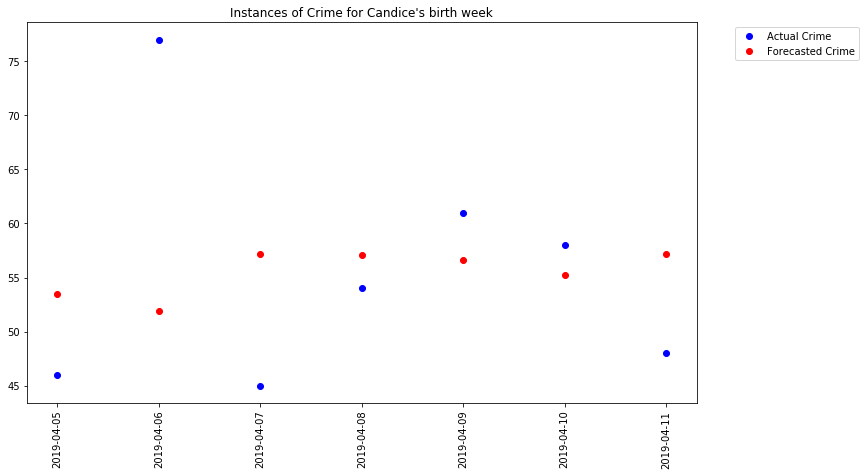

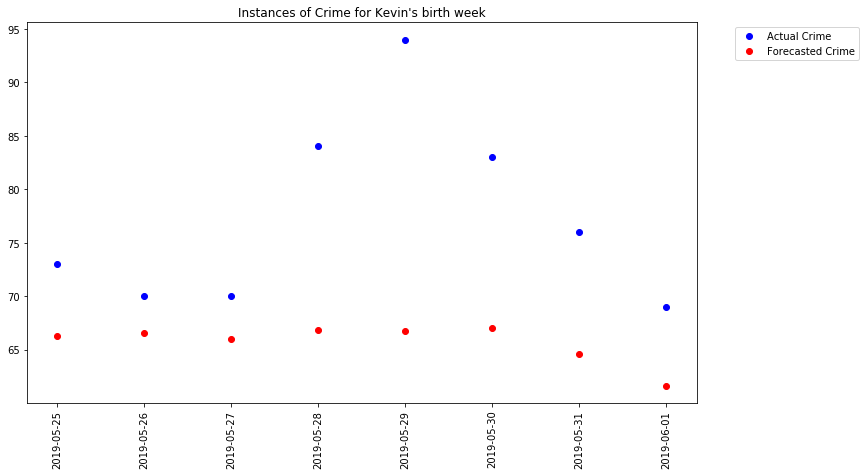

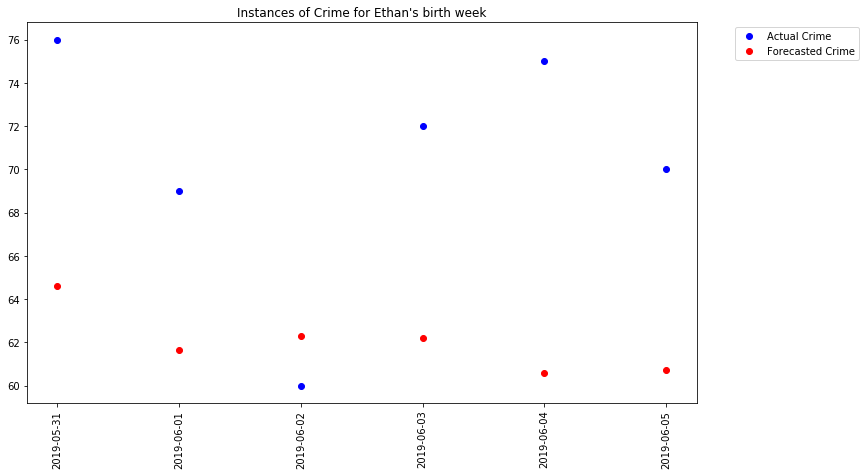

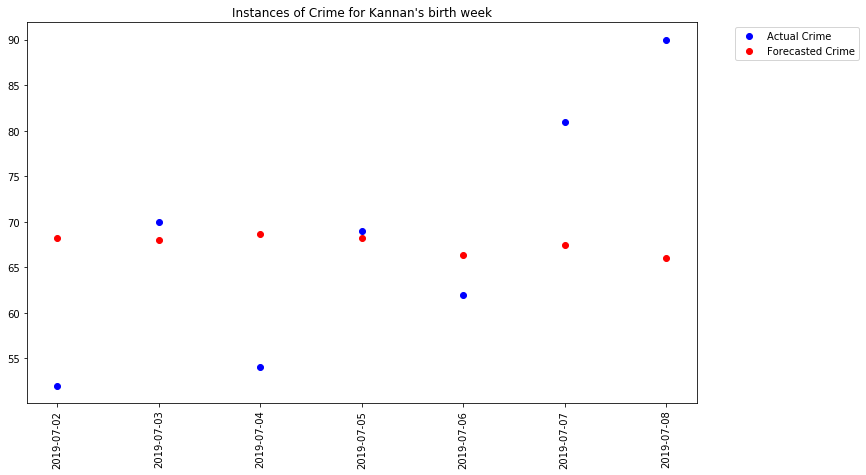

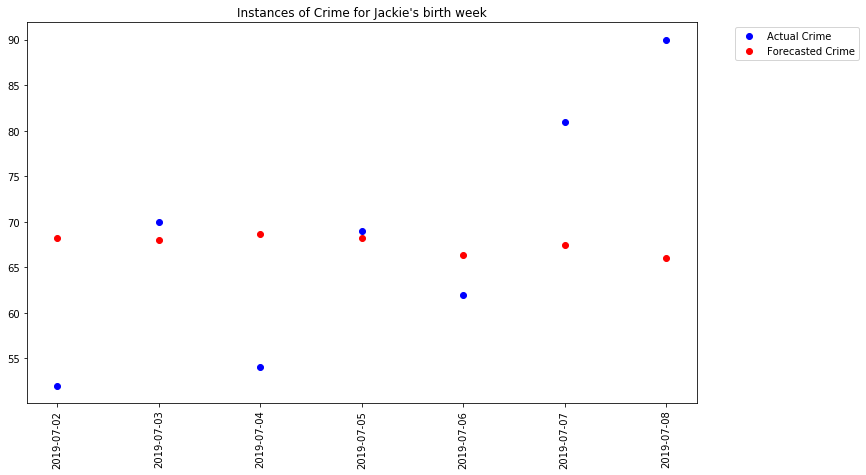

In [28]:
# y = [test_set0['All_Crime'], test_set0['forecasted_crime']]
names = ['Candice','Kevin','Ethan','Kannan','Jackie']
all_df = [test_set0,test_set1,test_set2,test_set3,test_set4]
count = 0
for each_df in all_df:
    
    # plt.plot_date(test_set0['date'],y)
    y = each_df['All_Crime']
    y1 = each_df['forecasted_crime']
    x = each_df['date']

    ax = plt.plot_date(x = x, y =y, color = 'b', label = 'Actual Crime')
    plt.plot_date(x = x, y = y1, color = 'r',label = 'Forecasted Crime')
    plt.legend(bbox_to_anchor =(1.05,1),loc = 'upper left')
    plt.xticks(rotation = 90)

    plt.title("Instances of Crime for {x}'s birth week".format(x = names[count]))

    plt.savefig(('../images/plot{num}.png'.format(num = count)),dpi = 300,bbox_inches = 'tight')
    count += 1
    plt.show()
